# Dependencies Loading

In [1]:
pip install boruta

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy as bp
import os
from pmdarima.arima import auto_arima

## Project Setup

In [58]:
raw_input_data_path = "/Users/filipecorreia/Desktop/ML_1/Clean_Dataset1.csv"
preprocessed_output_data_path = "/Users/filipecorreia/Desktop/ML_1/Clean_Dataset1.csv"

In [59]:
df=pd.read_csv('/Users/filipecorreia/Desktop/ML_1/Clean_Dataset1.csv')
df=df.drop('Unnamed: 0',axis=1)
df.sample(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
22672,Indigo,6E-2031,Delhi,Early_Morning,one,Afternoon,Kolkata,Economy,8.08,16,6443
299580,Vistara,UK-834,Chennai,Evening,one,Afternoon,Hyderabad,Business,19.42,37,51457
238215,Vistara,UK-988,Mumbai,Night,one,Morning,Hyderabad,Business,12.75,5,58125
49914,AirAsia,I5-942,Mumbai,Afternoon,one,Late_Night,Delhi,Economy,12.25,36,2336
53390,Air_India,AI-888,Mumbai,Evening,one,Morning,Bangalore,Economy,13.92,5,9201
6451,SpiceJet,SG-8169,Delhi,Evening,zero,Night,Mumbai,Economy,2.33,33,2456
247245,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,11.25,32,50361
245571,Vistara,UK-866,Bangalore,Night,one,Evening,Delhi,Business,19.25,11,54841
168116,Indigo,6E-531,Hyderabad,Early_Morning,one,Afternoon,Bangalore,Economy,7.58,27,2737
119049,Air_India,AI-804,Bangalore,Early_Morning,one,Evening,Chennai,Economy,12.83,42,6444


## One Dimentional Approach

#### Label Encoding ( Transform categorical data into numerical data )

In [60]:
from sklearn.preprocessing import LabelEncoder #import the LabelEncoder class from the sklearn.preprocessing module. This class is used to encode categorical labels into numerical values.

le = LabelEncoder()

cat_cols = ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

# Copy the DataFrame
df_orginal = df.copy()

# Apply label encoding to the specified columns
df[cat_cols] = df[cat_cols].apply(le.fit_transform)


# Display unique encoded values for each categorical column for Data Preprocessing in the Model deployment stage.
for column in cat_cols:
    unique_encoded_values = df[column].unique()   
    print(f"Unique encoded values for column '{column}' { df_orginal[column].unique()} : {unique_encoded_values}")

Unique encoded values for column 'airline' ['SpiceJet' 'AirAsia' 'Vistara' 'GO_FIRST' 'Indigo' 'Air_India'] : [4 0 5 2 3 1]
Unique encoded values for column 'flight' ['SG-8709' 'SG-8157' 'I5-764' ... '6E-7127' '6E-7259' 'AI-433'] : [1408 1387 1213 ...  558  587  718]
Unique encoded values for column 'source_city' ['Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai'] : [2 5 0 4 3 1]
Unique encoded values for column 'departure_time' ['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night'] : [2 1 4 0 5 3]
Unique encoded values for column 'stops' ['zero' 'one' 'two_or_more'] : [2 0 1]
Unique encoded values for column 'arrival_time' ['Night' 'Morning' 'Early_Morning' 'Afternoon' 'Evening' 'Late_Night'] : [5 4 1 0 2 3]
Unique encoded values for column 'destination_city' ['Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai' 'Delhi'] : [5 0 4 3 1 2]
Unique encoded values for column 'class' ['Economy' 'Business'] : [1 0]


Output: The provided results indicate the encoded numerical representations for categorical columns in the dataset. Notably, the 'airline' column has been encoded with values [4, 0, 5, 2, 3, 1] for categories like 'SpiceJet,' 'AirAsia,' 'Vistara,' and others. Similarly, other columns such as 'flight,' 'source_city,' 'departure_time,' 'stops,' 'arrival_time,' 'destination_city,' and 'class' have undergone encoding, allowing for the transformation of original categorical data into a numerical format suitable for analytical or machine learning purposes. For instance, the 'stops' column has been encoded as [2, 0, 1] for categories 'zero,' 'one,' and 'two_or_more.'

In [61]:
df.sample(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
6738,5,1523,2,2,0,0,5,1,20.83,34,5227
84135,3,497,0,4,0,5,2,1,9.67,1,14261
226312,5,1535,5,1,2,4,2,0,2.17,15,36700
259506,5,1511,0,2,0,4,1,0,13.83,16,44280
158177,4,1292,3,2,0,2,2,1,26.33,46,10121
203444,3,21,1,5,2,5,3,1,1.17,12,4202
187337,5,1483,1,1,0,5,2,1,13.67,48,4971
135878,5,1458,4,2,0,4,0,1,15.25,4,12166
125569,2,1108,4,0,0,2,2,1,6.08,38,6324
136181,3,195,4,4,2,0,0,1,2.83,7,6489


In [62]:
print("Rows with missing values:")
print(df[df.isnull().any(axis=1)])
df_cleaned = df.dropna()
print("\nDataFrame information after removing missing values:")
print(df_cleaned.info())

Rows with missing values:
Empty DataFrame
Columns: [airline, flight, source_city, departure_time, stops, arrival_time, destination_city, class, duration, days_left, price]
Index: []

DataFrame information after removing missing values:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  int64  
 1   flight            300153 non-null  int64  
 2   source_city       300153 non-null  int64  
 3   departure_time    300153 non-null  int64  
 4   stops             300153 non-null  int64  
 5   arrival_time      300153 non-null  int64  
 6   destination_city  300153 non-null  int64  
 7   class             300153 non-null  int64  
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(10)

Output: It indicates that there are no missing values in any row of the DataFrame after the removal operation. The cleaned DataFrame now consists of 300,153 entries with columns such as 'airline,' 'flight,' 'source_city,' 'departure_time,' 'stops,' 'arrival_time,' 'destination_city,' 'class,' 'duration,' 'days_left,' and 'price.' The data types for these columns have been appropriately identified, including 'int64' for most categorical and numerical columns, and 'float64' for the 'duration' column. The memory usage of the DataFrame is reported as 27.5 MB, signifying the successful removal of missing values.

# Interactions

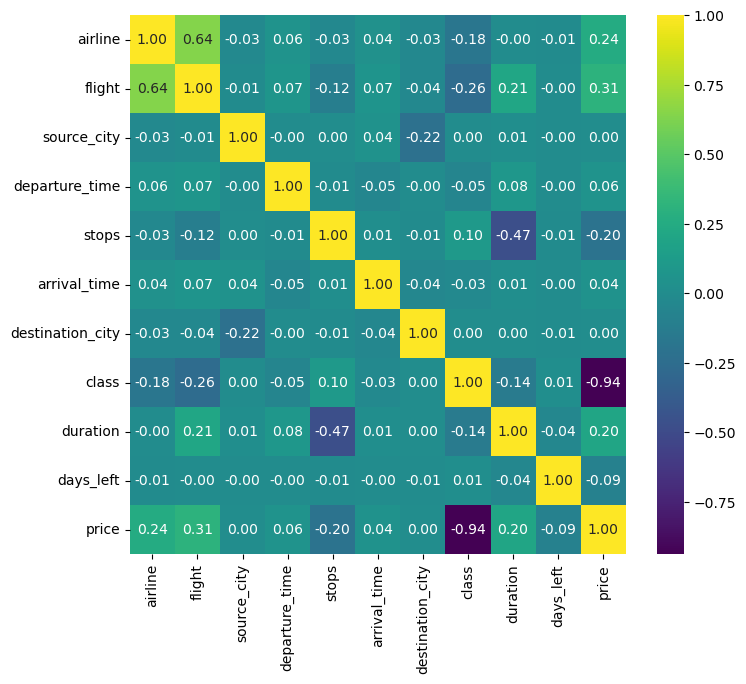

In [63]:
plt.figure(figsize=(8, 7))
sns.heatmap( df.corr(), annot=True, fmt=".2f", cmap="viridis")
plt.show()

Outcome: The heatmap indicates a strong correlation between the 'flight' and 'airline' variables. To address potential issues like multicollinearity during machine learning model training, we've decided to remove the 'flight' column from the dataset. Although 'airline' has a slightly lower correlation with the target variable 'price,' we've opted to eliminate 'flight' to simplify the model input. Additionally, it's noteworthy that 'source_city' and 'destination_city' show zero correlation with the target variable 'price.' Despite this, we've kept these variables in the dataset for further exploration using alternative feature selection methods.

In [64]:
df.drop('flight', axis = 1, inplace= True)

# Feature Selection

### Univariate Approach - Filter Methods

F-scores and P-values:
            Feature       F-Score        P-Value
0           airline  1.889488e+04   0.000000e+00
1       source_city  6.336078e+00   1.183113e-02
2    departure_time  1.024320e+03  2.225955e-224
3             stops  1.285024e+04   0.000000e+00
4      arrival_time  5.314825e+02  1.701642e-117
5  destination_city  6.901274e+00   8.613871e-03
6             class  2.192425e+06   0.000000e+00
7          duration  1.306315e+04   0.000000e+00
8         days_left  2.559274e+03   0.000000e+00


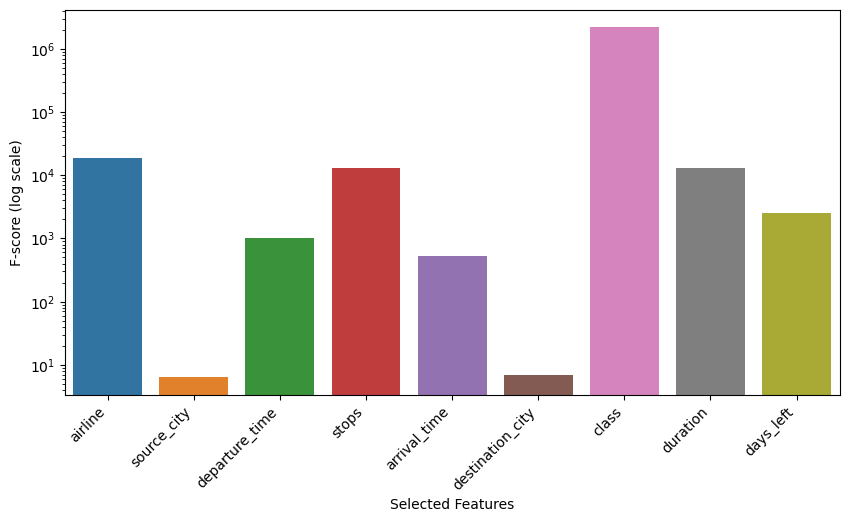

In [65]:
from sklearn.feature_selection import SelectKBest, f_regression

Y = df["price"]
X = df.drop(["price"], axis=1)

num_features_to_select = 7
selected_features = SelectKBest(f_regression, k=num_features_to_select).fit(X, Y)

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': selected_features.scores_,
    'P-Value': selected_features.pvalues_
})
print("F-scores and P-values:")
print(feature_scores)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_scores['Feature'], y=feature_scores['F-Score'])
plt.yscale('log')  # Use a logarithmic scale for better visualization
plt.title("")
plt.xlabel("Selected Features")
plt.ylabel("F-score (log scale)")
plt.xticks(rotation=45, ha="right")
plt.show()

In [66]:
selected_feature_names = X.columns[selected_feature_indices]
print("Selected features:", selected_feature_names)

selected_data = X[selected_feature_names]
print(selected_data.head())

Selected features: Index(['airline', 'departure_time', 'stops', 'arrival_time', 'class',
       'duration', 'days_left'],
      dtype='object')
   airline  departure_time  stops  arrival_time  class  duration  days_left
0        4               2      2             5      1      2.17          1
1        4               1      2             4      1      2.33          1
2        0               1      2             1      1      2.17          1
3        5               4      2             0      1      2.25          1
4        5               4      2             4      1      2.33          1


Output: Based on the results from feature selection using F-scores and p-values, it appears that certain columns have relatively lower importance in predicting the 'price' variable. Specifically, 'source_city,' and 'destination_city' exhibit comparatively lower F-scores and slightly higher p-values. Therefore, considering their limited impact on the target variable, we have decided to drop these columns from the dataset to streamline the input data for our model implementation. This simplification aims to improve model efficiency and interpretability by focusing on the more influential features such as 'flight,' 'airline,' 'class,' 'duration,' 'stops,' 'departure_time,' and 'days_left.'

In [67]:
features_to_drop = [col for col in df.columns if col not in selected_feature_names and col != 'price']
df.drop(features_to_drop, axis=1, inplace=True)
df

,airline,departure_time,stops,arrival_time,class,duration,days_left,price
0,4,2,2,5,1,2.17,1,5953
1,4,1,2,4,1,2.33,1,5953
2,0,1,2,1,1,2.17,1,5956
3,5,4,2,0,1,2.25,1,5955
4,5,4,2,4,1,2.33,1,5955
...,...,...,...,...,...,...,...,...
300148,5,4,0,2,0,10.08,49,69265
300149,5,0,0,5,0,10.42,49,77105
300150,5,1,0,5,0,13.83,49,79099
300151,5,1,0,2,0,10.00,49,81585


### Multivariate approach

#### Wrapper-Based method : Backward Elimination

In [68]:
import statsmodels.api as sm
Y = df["price"]
X = df.drop(["price"], axis=1)
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(Y,X_1).fit()
# model.pvalues

In [69]:
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['airline', 'departure_time', 'stops', 'arrival_time', 'class', 'duration', 'days_left']


Outcome: The backward elimination approach, a wrapper-based method for selecting features, has reached a stage where it ceases to remove any additional features.

### MIN-MAX Normalization (Part of One Dimentional Approach)

In [70]:
from sklearn.preprocessing import MinMaxScaler

new_min = 0
new_max = 1

duration_min = df['duration'].min()
duration_max = df['duration'].max()
days_left_min = df['days_left'].min()
days_left_max = df['days_left'].max()
price_min = df['price'].min()
price_max = df['price'].max()

scaler = MinMaxScaler(feature_range=(new_min, new_max))

num_cols = ['duration', 'days_left', 'price']

df[num_cols] = scaler.fit_transform(df[num_cols])

df.sample(10)

,airline,departure_time,stops,arrival_time,class,duration,days_left,price
268006,5,2,0,4,0,0.311224,0.250000,0.490899
152267,2,2,0,3,1,0.153061,0.916667,0.050235
15055,3,1,2,4,1,0.042653,0.520833,0.027836
35743,3,1,0,0,1,0.153061,0.083333,0.056122
296116,5,1,0,2,0,0.246735,0.104167,0.580613
275329,1,5,0,4,0,0.227959,0.250000,0.314793
199313,3,5,0,1,1,0.120816,0.333333,0.050924
214263,1,2,2,5,0,0.039184,0.604167,0.260351
246929,5,1,0,2,0,0.250000,0.562500,0.403850
107965,3,1,0,0,1,0.129388,0.770833,0.035412


Outcome: Following the execution of the models, it became evident that we encountered significant values for RMSE, MSE, and MAE. Recognizing the need for a more coherent comparison between the model results, we opted to normalize the numerical values using MinMaxScaler. 

In [71]:
df.to_excel("/Users/filipecorreia/Desktop/ML_1/Clean_Dataset2.xlsx")